In [5]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, hnn_noise_conn_prob_param_function,
                   load_posterior, simulator_hnn, 
                   get_parameter_recovery, get_posterior_predictive_check)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

data_path = f'../data/noise_EI_connprob'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples'] 
theta_extra = sim_metadata['theta_extra']

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_noise_conn_prob_param_function,
                    network_model=net, theta_extra=theta_extra, tstop=tstop, return_objects=True)

In [12]:
%matplotlib inline
# Values on [0,1] mapped to range of bounds defined in prior_dict
#theta_cond_list = [np.array([0.15, 0.85, 0.85]), np.array([0.85, 0.85, 0.85])]
theta_cond_list = [np.array([0.55, 0.05, 0.55, 0.55]), np.array([0.55, 0.95, 0.55, 0.55])]

dpl_cond_list, theta_dict_list, spike_gids_list, net_list = list(), list(), list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}
    
    net, dpl = simulator(torch.tensor(theta_cond).float())[0]
    dpl_data = np.array(dpl[0].copy().smooth(20).data['agg'][window_samples[0]:window_samples[1]])
    dpl_cond_list.append(dpl_data.reshape(1,-1))
    spike_gids_list.append([net.cell_response.spike_gids[0]])
    net_list.append(net)
    #x_cond = x_cond[:,window_samples[0]:window_samples[1]]
                   
    #theta_dict_list.append(theta_dict)
    #x_cond_list.append(x_cond.numpy())
    #net_list.append(net)



{'EI_prob': 0.550000011920929, 'EE_prob': 0.05000000074505806, 'II_prob': 0.550000011920929, 'IE_prob': 0.550000011920929}
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Tri

In [13]:
dpl_orig, theta_orig = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
dpl_orig = dpl_orig[:,window_samples[0]:window_samples[1]]
spike_gids_orig = np.load(f'{data_path}/sbi_sims/spike_gids_sbi.npy', allow_pickle=True)

raw_data_type = {'dpl': {'train': dpl_orig, 'cond': dpl_cond_list}}

#dpl_grid, theta_grid = np.load(f'{data_path}/sbi_sims/dpl_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')
#dpl_grid = dpl_grid[:,window_samples[0]:window_samples[1]]

In [8]:
dpl_noise_amp = posterior_metadata['x_noise_amp']
dpl_noise = rng.normal(loc=0.0, scale=dpl_noise_amp, size=dpl_orig.shape)
dpl_orig_noise = dpl_orig + dpl_noise

In [9]:
posterior_state_dicts.keys()

dict_keys(['scalefree_slope'])

In [10]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# Collect plotting data outside loop
scatter_data_list = list()
dist_data_list = list()
ppc_data_list = list()
theta_data_list = list()

input_type_list = ['scalefree_slope']


for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, theta_cond_transformed_list = list(), list()
    cond_name = ['Cond1', 'Cond2']
    x_orig = raw_data_type[input_dict['data_type']]['train']
    x_cond_list = raw_data_type[input_dict['data_type']]['cond']
    
    for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
        load_info = {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                     'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info['x_cond']))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        theta_cond_transformed_list.append(theta_cond_transformed)
        df_list.append(df_temp)
    df = pd.concat(df_list)
    
    scatter_data_list.append(df)
        
    # Parameter recovery
    #dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    #dist_data_list.append(dist_array)


    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    #ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    #ppc_data_list.append(ppc_array)
    
    theta_data_list.append(theta_cond_transformed_list)


Conditioning Feature: scalefree_slope
 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples: 1114it [00:00, 25173.78it/s]            


 Training neural network. Epochs trained: 3

Drawing 1000 posterior samples: 1083it [00:00, 44760.95it/s]            


scalefree_slope


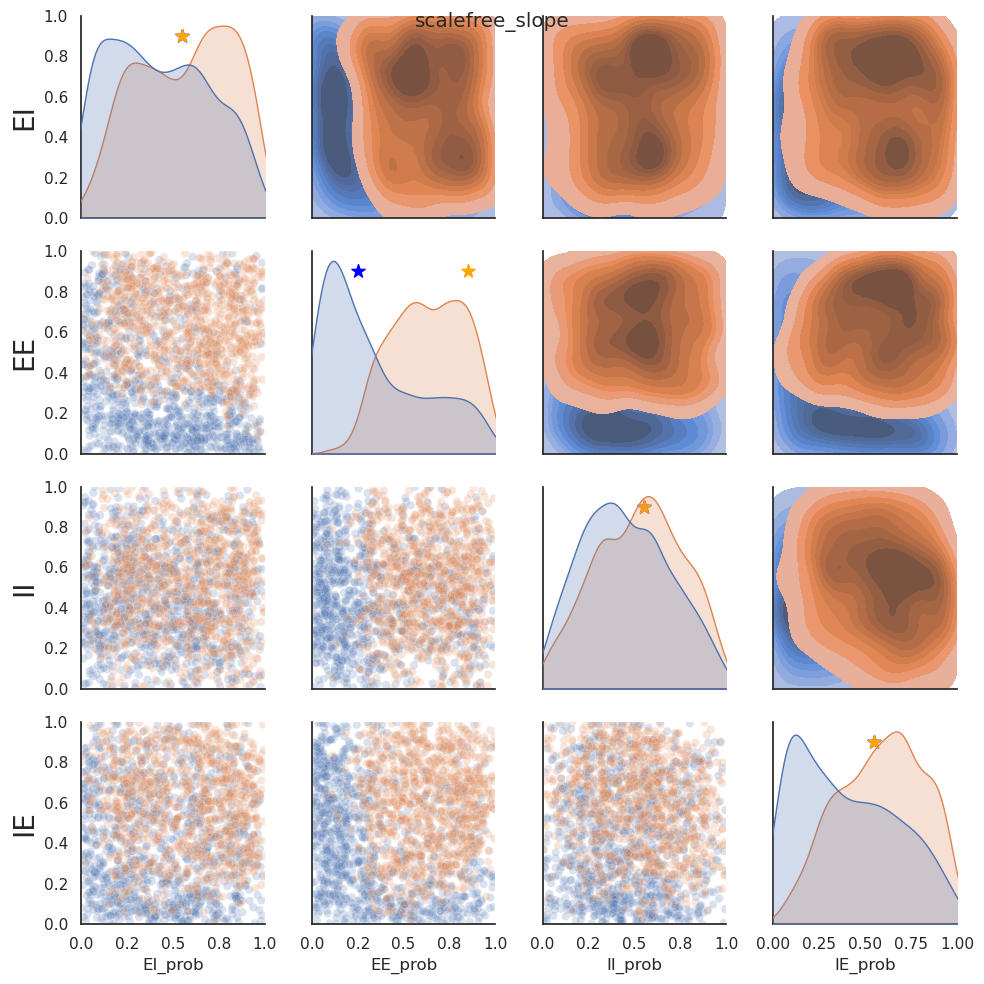

In [11]:
for feature_idx in range(len(input_type_list)):
    print(input_type_list[feature_idx])

    labelsize=20

    param_labels = ['EI', 'EE', 'II', 'IE']

    df = scatter_data_list[feature_idx]
    theta_cond_transformed_list = theta_data_list[feature_idx]

    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
    g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
    g.map_lower(sns.scatterplot, alpha=0.2)
    g.map_upper(sns.kdeplot, fill=True)
    g.map_diag(sns.kdeplot, fill=True)

    for idx in range(4):    
        # Add space to visuzalize groundtruth tick marks at top
        y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

        g.axes[idx, idx].set_xlim(all_bounds[idx])
        g.axes[idx, idx].set_ylim(all_bounds[idx])

        g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
                                color='blue', marker='*', s=100)
        g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
                                color='orange', marker='*', s=100)

        g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
        g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

    for idx1 in range(4):
        for idx2 in range(3):
            if g.axes[idx1, idx2] != None:
                g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tight_layout()
    plt.suptitle(input_type_list[feature_idx])
#plt.savefig('hnn_erp_posterior_compare.svg')